In [61]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_dataset.csv', 'test_dataset.csv']


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics, ensemble
# import lightgbm as lgb

# Question 1

## 1a)

In [63]:
data = pd.read_csv("../input/train_dataset.csv")
test = pd.read_csv("../input/test_dataset.csv")
# whole_data = pd.concat([data.drop('IsBadBuy',axis=1),test])
data.head()

,RT13Id,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,PaintingBCost,IsOnlineSale,WarrantyCost
0,21003,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,...,13641.0,14951.0,NaN,NaN,8655,75236,TX,8160.0,0,920
1,57560,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,...,6122.0,7474.0,NaN,NaN,22808,71119,LA,6870.0,0,853
2,29868,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,...,13509.0,15918.0,NaN,NaN,20928,32824,FL,8680.0,0,1373
3,64473,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,...,5243.0,6541.0,NaN,NaN,21053,85226,AZ,4830.0,0,2508
4,68666,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,...,8228.0,9300.0,NaN,NaN,22916,80817,CO,4965.0,0,671


In [64]:
test_rate = 0.3
test_size = int(data.shape[0] * test_rate)
# shuffle the data frame rows without producing new index
def split_set(data, test_size):
    data = data.sample(frac=1).reset_index(drop=True)
    return np.split(data, [test_size], axis=0)
test_data, train_data = split_set(data, test_size)
print(train_data.shape, test_data.shape)
train_data.head()

(35762, 34) (15326, 34)


,RT13Id,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,PaintingBCost,IsOnlineSale,WarrantyCost
15326,18745,0,1/27/2009,Christie's,2005,4,Qu Ding,GRAND PRIX 3.8L T6 S,Bas,4D Genre,...,6670.0,8017.0,NaN,NaN,22916,80022,CO,5480.0,0,1974
15327,49865,0,8/5/2009,OTHER,2004,5,Pablo Picasso,STRATUS T6 2.7L T6 M,SE,4D Genre SE,...,5817.0,7704.0,NaN,NaN,835,85009,AZ,4975.0,0,1215
15328,65969,0,4/23/2009,Sotheby's,2004,5,Pablo Picasso,NEON 2.0L I4 T11I,SE,4D Genre,...,3486.0,4559.0,NaN,NaN,17675,28273,NC,4005.0,0,588
15329,67174,0,5/6/2009,Sotheby's,2003,6,Grandma Moses,Hounds 2.0L I4 SPI,SE,4D Genre SE,...,3496.0,4544.0,NaN,NaN,20207,77086,TX,3175.0,0,1220
15330,68961,1,9/10/2009,Sotheby's,2004,5,Giovanni,LIBERTY T1 T6 3.7L,Spo,4D other,...,7757.0,9668.0,NaN,NaN,21973,32219,FL,6900.0,0,983


## 1b)

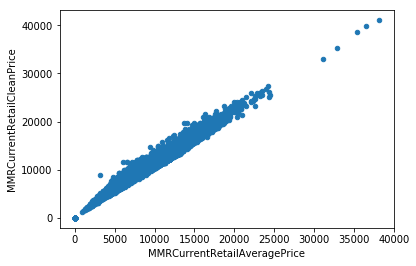

In [65]:
plt.figure(figsize=[16,9], dpi=100)
data.plot.scatter("MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice")
plt.show()

**It seems that it is linear.**

## 1c)

In [66]:
data.columns

Index(['RT13Id', 'IsBadBuy', 'PurchDate', 'Auction', 'PaintingYear',
       'PaintingAge', 'Artist', 'PaintingName', 'Trim', 'SubType',
       'CanvasColor', 'Market', 'FrameTypeID', 'FrameType', 'Bids',
       'Nationality', 'Size', 'TopThreeNYCName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1', 'VNST', 'PaintingBCost',
       'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

In [67]:
need_to_plot = ['PaintingAge', 'Bids', 'WarrantyCost', 'PaintingBCost']
def plot_one_distribution(name):
    plt.figure(figsize=(16, 9))
    sns.distplot(data[name].values, bins=128, kde=False, color='g')
    plt.xlabel(name, fontsize=12)
    plt.ylabel('Number', fontsize=12)
    plt.title("{} Histogram".format(name), fontsize=16)
    plt.show()

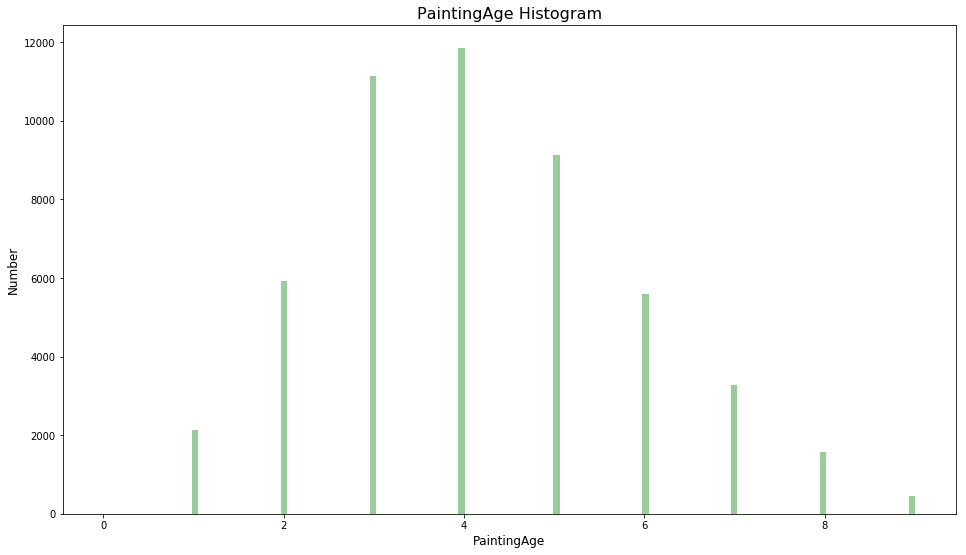

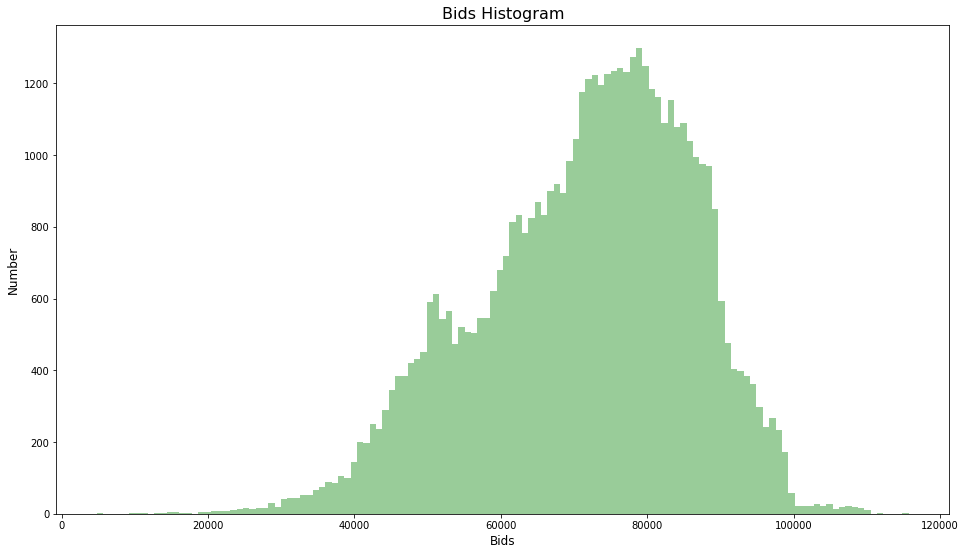

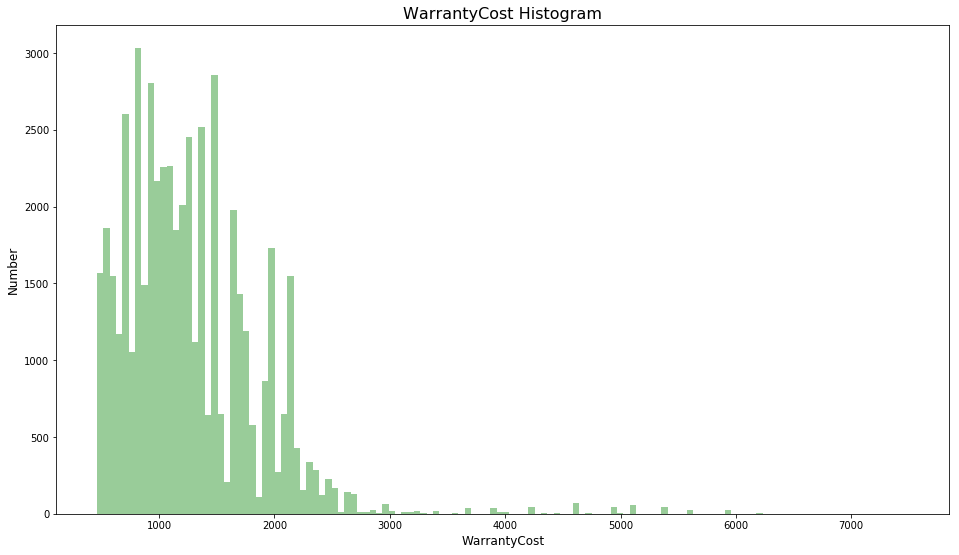

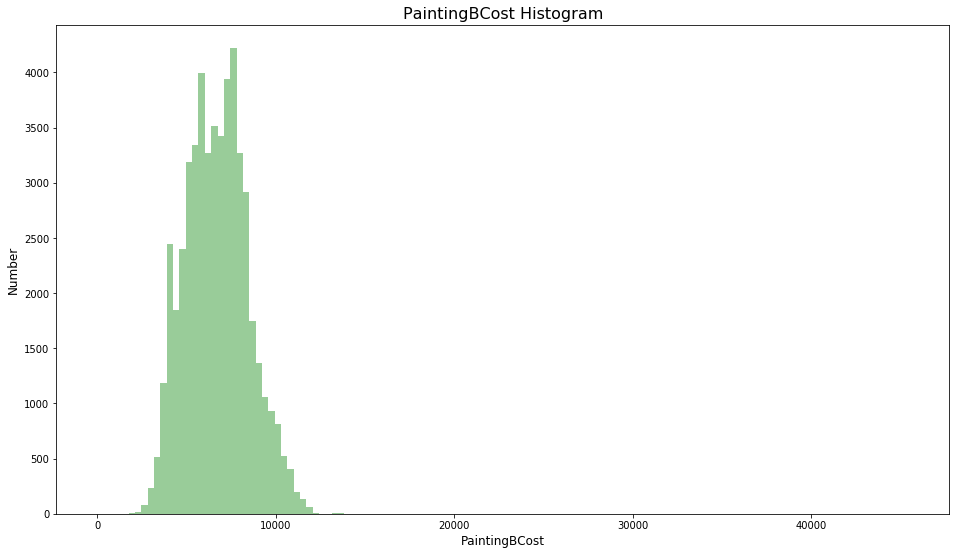

In [68]:
for n in need_to_plot:
    plot_one_distribution(n)

**Basically, all distributions are skewed. while 'painting age is slightly skewed, but bids and warranty cost are extremely skewed.**

# Question 2

## 2a)

In [69]:
data = data.drop('RT13Id', axis=1)
data.head()

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,PaintingBCost,IsOnlineSale,WarrantyCost
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,13641.0,14951.0,NaN,NaN,8655,75236,TX,8160.0,0,920
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,6122.0,7474.0,NaN,NaN,22808,71119,LA,6870.0,0,853
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,13509.0,15918.0,NaN,NaN,20928,32824,FL,8680.0,0,1373
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,5243.0,6541.0,NaN,NaN,21053,85226,AZ,4830.0,0,2508
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,8228.0,9300.0,NaN,NaN,22916,80817,CO,4965.0,0,671


## 2b)

In [70]:
import re
categories = data[['PaintingName', 'SubType']]

In [71]:
def extract_one_cate(name, subtype, values, idx):
    pattern = re.compile(r"T\d+")
    r1 = pattern.finditer(name)
    for rr in r1:
        values[idx][int(rr.group().replace("T", "")) - 1] = 1
    if not pd.isnull(subtype):
        r2 = pattern.finditer(subtype)
        for rr in r2:
            values[idx][int(rr.group().replace("T", "")) - 1] = 1
    if sum(values[idx]) == 0:
        values[idx][-1] = 1
    return

In [72]:
one_hot_values = np.zeros([data.shape[0], 14])
for idx, row in categories.iterrows():
    extract_one_cate(row[0], row[1], one_hot_values, idx)
one_hot_values[:5]

array([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [73]:
# the last column means the category T is not given
for i in range(14):
    data["T{}".format(i + 1)] = one_hot_values[:, i]
data.head()

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 2c)

In [74]:
def extract_one_num_check(name, values, idx):
    pattern = re.compile(r"I.?\d")
    outpattern = re.compile(r"\d+")
    r = pattern.search(name)
    if r:
        rr = outpattern.search(r.group()).group()
        values[idx] = int(rr)
        return

In [75]:
# 0 here means not given
num_check = np.zeros(data.shape[0])
names = data[['PaintingName']]
for idx, row in names.iterrows():
    extract_one_num_check(row[0], num_check, idx)
num_check[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 4., 0.])

In [76]:
data["num_checked"] = num_check

## 2d)

In [77]:
def extract_one_size(name, values, idx):
    pattern = re.compile(r"\d.?\d?L")
    outpattern = re.compile(r"\d.?\d?")
    r = pattern.search(name)
    if r:
        rr = outpattern.search(r.group()).group()
        values[idx] = float(rr)
        return

In [78]:
# zeros here means not given
sizes = np.zeros(data.shape[0])
names = data[['PaintingName']]
for idx, row in names.iterrows():
    extract_one_size(row[0], sizes, idx)
sizes[:10]

array([0. , 3.9, 0. , 0. , 0. , 0. , 0. , 0. , 2. , 0. ])

In [79]:
data["given_size"] = sizes

## 2e)

In [80]:
_cates = ['Not Given', 'Genre', 'History', 'Still Life', 'Real Life', 'Landscape', 'Portrait', 'Fine Art']
cates_to_id = {v: k for k, v in enumerate(_cates)}
id_to_cates = {k: v for k, v in enumerate(_cates)}

In [81]:
def extract_one_cate_2(subt, _cates, dic, values, idx):
    for c in _cates:
        if  not pd.isnull(subt) and subt.find(c) >= 0:
            values[idx] = dic[c]
            return
    return

In [82]:
types = data[['SubType']]
cates_2 = np.zeros(data.shape[0], np.int8)
for idx, row in types.iterrows():
    extract_one_cate_2(row[0], _cates, cates_to_id, cates_2, idx)
print(cates_2[:10])
for t in cates_2[:10]:
    print(id_to_cates[t])

[0 5 1 1 1 1 0 1 1 6]
Not Given
Landscape
Genre
Genre
Genre
Genre
Not Given
Genre
Genre
Portrait


In [83]:
df_tmp = pd.DataFrame({'cate_': [id_to_cates[t] for t in cates_2]})
df_tmp = pd.get_dummies(df_tmp, prefix=['cate_'], drop_first=True)
data = pd.concat([data, df_tmp], axis=1)
data.head()

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,T14,num_checked,given_size,cate__Genre,cate__History,cate__Landscape,cate__Not Given,cate__Portrait,cate__Real Life,cate__Still Life
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,0.0,0.0,0.0,0,0,0,1,0,0,0
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,0.0,0.0,3.9,0,0,1,0,0,0,0
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,0.0,0.0,0.0,1,0,0,0,0,0,0
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,0.0,0.0,0.0,1,0,0,0,0,0,0
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,1.0,0.0,0.0,1,0,0,0,0,0,0


## 2f)

In [84]:
prices = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',]
for p in prices:
    data = data.loc[data[p] != 0]
    data["{}_ratio".format(p)] = data["Bids"] / data[p]

data.head()

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,cate__Real Life,cate__Still Life,MMRAcquisitionAuctionAveragePrice_ratio,MMRAcquisitionAuctionCleanPrice_ratio,MMRAcquisitionRetailAveragePrice_ratio,MMRAcquisitonRetailCleanPrice_ratio,MMRCurrentAuctionAveragePrice_ratio,MMRCurrentAuctionCleanPrice_ratio,MMRCurrentRetailAveragePrice_ratio,MMRCurrentRetailCleanPrice_ratio
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,0,0,8.575855,7.490121,6.209689,5.602900,8.104874,7.167936,5.863720,5.349943
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,0,0,15.002756,12.026510,12.803387,10.425124,15.685747,12.646740,13.338778,10.925876
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,0,0,7.956712,7.132863,6.008796,5.527849,8.233203,7.191053,6.068399,5.150019
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,0,0,33.343656,23.385822,14.476937,12.280057,33.487689,23.231645,14.786191,11.852010
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,0,0,10.798450,9.091841,6.870934,6.042136,12.008621,10.038778,7.110598,6.290968


## 2g)

In [85]:
factors = ["Artist", "CanvasColor","Market","Nationality","Auction"]

for f in factors:
    df_tmp = data[[f]]
    df_tmp = pd.get_dummies(df_tmp, prefix=[f], drop_first=True)
    data = pd.concat([data, df_tmp], axis=1)
data.head(20)

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,CanvasColor_RED,CanvasColor_SILVER,CanvasColor_WHITE,CanvasColor_YELLOW,Market_Non Commercial,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,Auction_OTHER,Auction_Sotheby's
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,0,1,0,0,0,0,1,0,0,0
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,0,1,0,0,0,0,0,0,0,1
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,0,1,0,0,0,0,0,0,0,0
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,0,0,0,0,0,0,0,0,0,1
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,1,0,0,0,0,0,0,0,0,1
5,0,1/13/2010,Sotheby's,2006,4,Michelangelo,David,Bas,4D Genre,GREY,...,0,0,0,0,0,0,0,1,0,1
6,1,2/19/2009,Christie's,2003,6,Leonardo Da Vinci,TRAILBLAZER T2 T8 4,LS,4D other 4.2L LS,GREEN,...,0,0,0,0,0,0,0,0,0,0
7,0,1/21/2010,Christie's,2006,4,Qu Ding,G6 T6,Bas,4D Genre,RED,...,1,0,0,0,0,0,0,0,0,0
8,1,9/3/2009,Christie's,2005,4,Pablo Picasso,NEON 2.0L I4 T11I,SXT,4D Genre,RED,...,1,0,0,0,0,0,0,0,0,0
9,0,1/27/2009,Christie's,2005,4,Pablo Picasso,CARAEnlarged GRAND T4 T6,SE,Portrait 3.3L,GOLD,...,0,0,0,0,0,0,0,0,0,0


In [86]:
f = "PaintingYear"
unique_years = list(set(data[f].tolist()))
dic = {v: k for k, v in enumerate(unique_years)}
years = [dic[y] for y in data[f].tolist()]
yys = np.zeros([data.shape[0], len(dic)])
for i, y in enumerate(years):
    yys[i][y] = 1

for i, k in enumerate(dic):
    data[str(k)] = yys[:, i]
data.head()

,IsBadBuy,PurchDate,Auction,PaintingYear,PaintingAge,Artist,PaintingName,Trim,SubType,CanvasColor,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,0,4/21/2010,Christie's,2007,3,Cai Jin,TUCSON T2 T7,GLS,4D other,SILVER,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,4/1/2009,Sotheby's,2004,5,Grandma Moses,Moses T6 3.9L T6 E,Bas,2D Landscape,SILVER,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3/31/2010,Christie's,2008,2,Frida Kahlo,AURA T6,XE,4D Genre XE,SILVER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,6/16/2010,Sotheby's,2003,7,Leonardo Da Vinci,MALIBU T6,Bas,4D Genre,GOLD,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,11/4/2010,Sotheby's,2007,3,Leonardo Da Vinci,COBALT,LS,4D Genre LS,RED,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Question 3

In [87]:
# More feature engineering here

In [88]:
#separating day, month, year from purchase date

In [89]:
purdate = ['purchase_Month','purchase_Day','purchase_Year']

In [90]:
for idx in range(len(purdate)):
    data[purdate[idx]] = data['PurchDate'].map(lambda x: int(x.split('/')[idx]))

In [91]:
# now we have prepared the training dataset already, we will filter out the predictors to build predictive models

In [92]:
features_not_used = ['PurchDate',"Auction",'PaintingYear','Artist','PaintingName','Trim','SubType',
                     'CanvasColor','Market','FrameType','TopThreeNYCName','Size',"PRIMEUNIT",
                    "AUCGUART","VNST","Nationality"]
data_train = data.drop(features_not_used,axis=1)
data_train = data_train.dropna(axis=0)
data_train = data_train

In [93]:
from sklearn.model_selection import cross_val_score
X = data_train.drop('IsBadBuy',axis=1)
y = data_train['IsBadBuy']

In [94]:
# model performance
model_name = []
model_accuracy = []

In [95]:
## logistic regression

In [96]:
from sklearn.linear_model import LogisticRegression 
 
glm_fit = LogisticRegression()  # 使用类，参数全是默认的
scores_glm = cross_val_score(glm_fit, X, y,cv=5).mean()

In [97]:
model_name.append('logistic')
model_accuracy.append(scores_glm)
scores_glm

0.9042922827965787

In [98]:
##Knn

In [99]:
from sklearn.neighbors import KNeighborsClassifier
# model_knn = KNeighborsClassifier(n_neighbors = 1)
# cross_val_score(model_knn,X,y,cv=5).mean()
score = []
for k in range(10):
    model_knn = KNeighborsClassifier(n_neighbors = k+1)
    score.append(cross_val_score(model_knn,X,y,cv=5).mean())

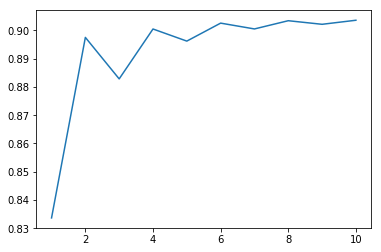

In [100]:
plt.plot(np.array(range(10))+1 ,score)
plt.show()

In [101]:
knn_acc = max(score)
model_name.append('knn')
model_accuracy.append(knn_acc)
knn_acc

0.9036265003708437

In [102]:
#####random forest

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [104]:
clf_dt = DecisionTreeClassifier(max_depth=None, 
                                min_samples_split=2,random_state=0)
scores_dt = cross_val_score(clf_dt, X, y,cv=5).mean()
print(scores_dt)    

 
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=None,
                                min_samples_split=2, random_state=0)
scores_rf = cross_val_score(clf_rf, X, y,cv=5).mean()
print(scores_rf)

clf_et = ExtraTreesClassifier(n_estimators=10, max_depth=None,
                              min_samples_split=2, random_state=0)
scores_et = cross_val_score(clf_et, X, y,cv=5).mean()
print(scores_et)

0.8189666909220369
0.9027318222276595
0.9000270562313769


In [105]:
rf_acc = max(scores_dt,scores_rf,scores_et)
model_name.append('random forest')
model_accuracy.append(rf_acc)
rf_acc

0.9027318222276595

In [106]:
feat = X.columns

In [107]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=None,
                                min_samples_split=2, random_state=0)
clf_rf_fit = clf_rf.fit(X,y)
importances = clf_rf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" %(f+1,30,feat[f],importances[indices[f]]))

 1) PaintingAge                    0.041733
 2) FrameTypeID                    0.041544
 3) Bids                           0.040878
 4) MMRAcquisitionAuctionAveragePrice 0.039208
 5) MMRAcquisitionAuctionCleanPrice 0.038716
 6) MMRAcquisitionRetailAveragePrice 0.037156
 7) MMRAcquisitonRetailCleanPrice  0.037007
 8) MMRCurrentAuctionAveragePrice  0.036681
 9) MMRCurrentAuctionCleanPrice    0.036547
10) MMRCurrentRetailAveragePrice   0.036486
11) MMRCurrentRetailCleanPrice     0.036365
12) BYRNO                          0.036227
13) VNZIP1                         0.035952
14) PaintingBCost                  0.035571
15) IsOnlineSale                   0.035288
16) WarrantyCost                   0.035246
17) T1                             0.035169
18) T2                             0.035139
19) T3                             0.033085
20) T4                             0.029642
21) T5                             0.028236
22) T6                             0.028222
23) T7                    

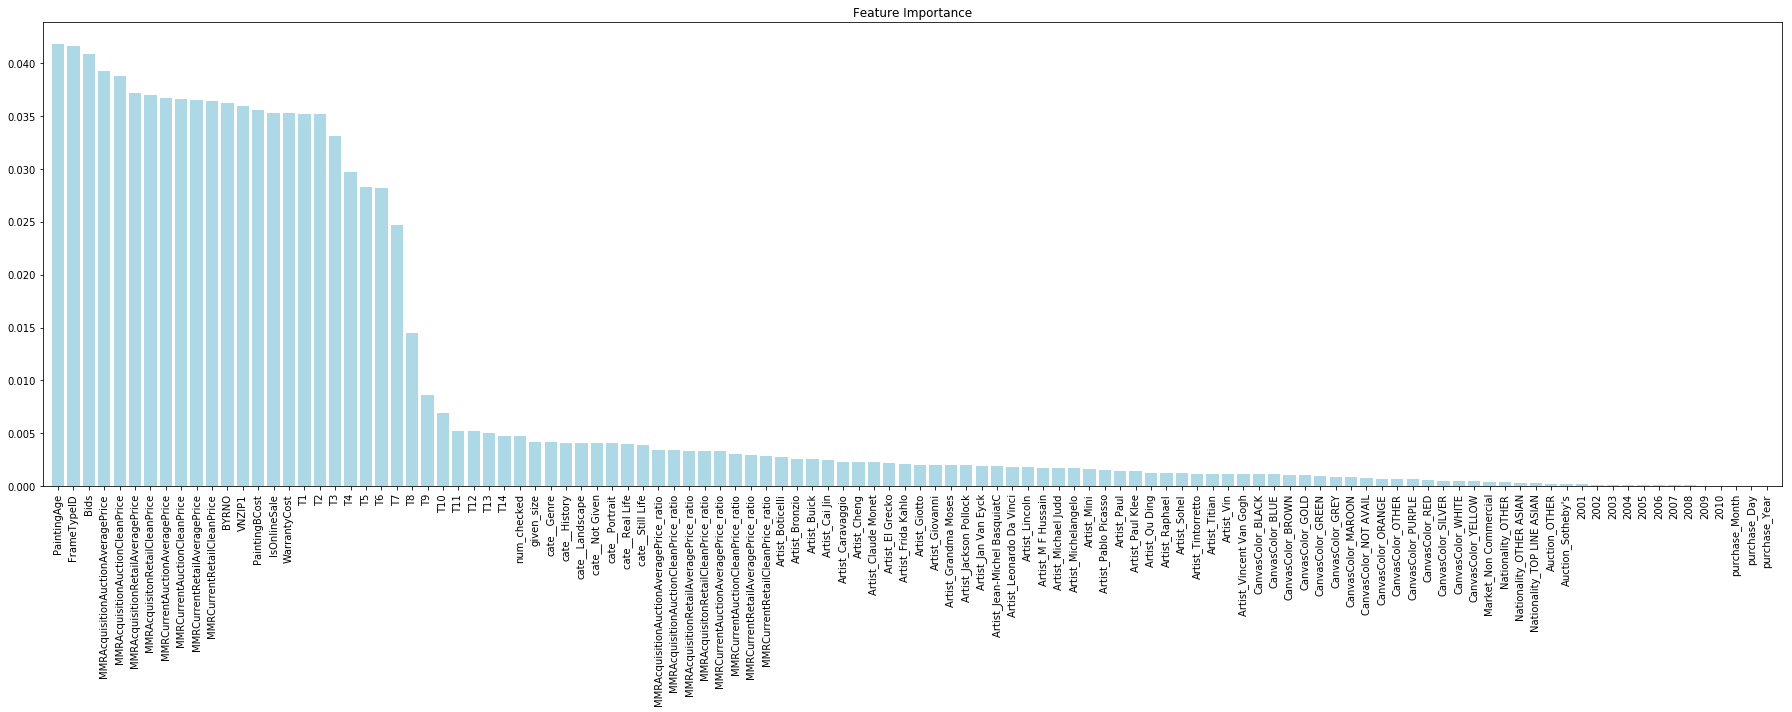

In [108]:
# plot the importance matrix
plt.figure(figsize=(25,10)) 
plt.title('Feature Importance')
plt.bar(range(X.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X.shape[1]),
          feat,rotation=90)
plt.xlim([-1,X.shape[1]])
plt.tight_layout()
plt.show()

In [109]:
# use the first 25 variables
top20feat = feat[:25]
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=None,
                                min_samples_split=2, random_state=0)
scores_rf = cross_val_score(clf_rf, X[top20feat], y,cv=5).mean()
print(scores_rf)  

0.9015042485426108


**SVM needs a lot of time for training, so here I comment the code **

In [110]:
######SVM

In [111]:
#svm（linear、rbf、sigmoid）
# from sklearn import svm
# clf_linear = svm.SVC(kernel='linear')
# clf_rbf = svm.SVC(kernel='rbf')
# clf_sigmoid = svm.SVC(kernel='sigmoid')

# score_svm_linear = cross_val_score(clf_linear, X, y,cv=5).mean()
# print(score_svm_linear)
# score_svm_rbf = cross_val_score(clf_linear, X, y,cv=5).mean()
# print(score_svm_rbf)
# score_svm_sigmoid = cross_val_score(clf_linear, X, y,cv=5).mean()
# print(score_svm_sigmoid)

# score_svm = max(score_svm_linear,score_svm_rbf,score_svm_sigmoid)
# model_name.append('svm')
# model_accuracy.append(score_svm)
# score_svm

In [112]:
####xgboost

In [113]:
# from sklearn.cross_validation import train_test_split
import xgboost as xgb
test_size = int(data.shape[0] * 0.33)
test_X, train_X = split_set(X, test_size)
test_Y, train_Y = split_set(y, test_size)
# train_X,test_X,train_Y,test_Y = train_test_split(X, y, test_size=0.33, random_state=42)
xg_train = xgb.DMatrix(train_X, label=train_Y)  
xg_test = xgb.DMatrix(test_X, label=test_Y) 

# setup parameters for xgboost  
selection = dict()
param = {}  
# use softmax multi-class classification  
param['objective'] = 'multi:softprob'  
# scale weight of positive examples  
param['num_class'] = 2 
param['silent'] = 0 
param['eta'] = 0.05
param['max_depth'] = 1
param['nthread'] = 1
param['eval_metric']='mlogloss'
num_round = 30
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]  
xgbst = xgb.train(param, xg_train, num_round, watchlist )

yprob = xgbst.predict(xg_test)
ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro  
xg_accuracy = (ylabel == test_Y).mean()

# for eta in [0.05,0.1,0.2,0.3]:
#     param['eta'] = eta
#     for max_depth in range(1,40,2):
#         param['max_depth'] = max_depth    
#         for nthread in range(1,11,1):
#             param['nthread'] = nthread  
#             # param['eval_metric']='mlogloss'
#             param['eval_metric']='mlogloss'
#             num_round = 30

#             watchlist = [ (xg_train,'train'), (xg_test, 'test') ]  
#             xgbst = xgb.train(param, xg_train, num_round, watchlist )

#             yprob = xgbst.predict(xg_test)
#             ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro  
#             xg_accuracy = (ylabel == test_Y).mean()
# #             selection.append({'xg_accuracy':xg_accuracy,'eta':eta,'max_depth':max_depth,'nthread':nthread})
#             print(xg_accuracy,eta,max_depth,nthread)
# 0.904284685549688 0.05 1 1


[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-mlogloss:0.661168	test-mlogloss:0.661329
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	train-mlogloss:0.632257	test-mlogloss:0.63257
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	train-mlogloss:0.606037	test-mlogloss:0.606496
[17:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 e

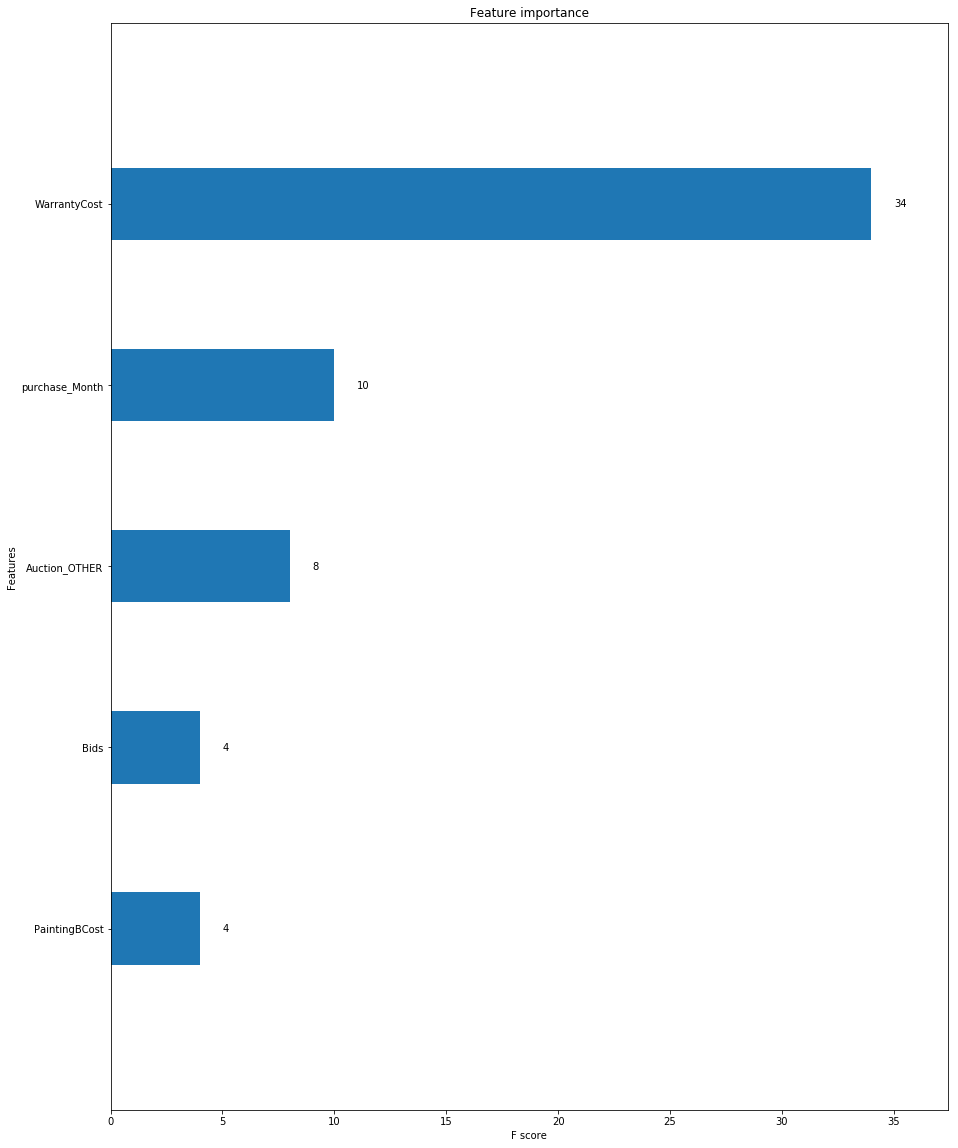

In [114]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,20))
plot_importance(xgbst,height=0.4,max_num_features=60,ax=ax,grid=False)
plt.show()

In [115]:
yprob = xgbst.predict(xg_test)
ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro  
xg_accuracy = (ylabel == test_Y).mean()
xg_accuracy

0.903084493518963

In [116]:
xgbst_new = xgb.train(param, xg_train, 30, watchlist )

[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-mlogloss:0.661168	test-mlogloss:0.661329
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	train-mlogloss:0.632257	test-mlogloss:0.63257
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	train-mlogloss:0.606037	test-mlogloss:0.606496
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 e

In [117]:
yprob = xgbst_new.predict(xg_test)
ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro  
xg_accuracy_new = (ylabel == test_Y).mean()
model_name.append('xgboost')
model_accuracy.append(xg_accuracy_new)
xg_accuracy_new

0.903084493518963

In [118]:
##neural network

In [120]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
clf_nn = MLPClassifier(hidden_layer_sizes=(32, 8), random_state=1)

scores_nn = cross_val_score(clf_nn, X, y,cv=5).mean()
print(scores_nn)

0.9042506703127211


In [121]:
model_name.append('neural network')
model_accuracy.append(scores_nn)

In [122]:
# transform test dataset into the target foramt.
def transform(data, _cates, cates_to_id, id_to_cates, unique_years, dic):
    data = data.drop('RT13Id', axis=1)
    categories = data[['PaintingName', 'SubType']]
    one_hot_values = np.zeros([data.shape[0], 14])
    for idx, row in categories.iterrows():
        extract_one_cate(row[0], row[1], one_hot_values, idx)
    # the last column means the category T is not given
    for i in range(14):
        data["T{}".format(i + 1)] = one_hot_values[:, i]

    # 0 here means not given
    num_check = np.zeros(data.shape[0])
    names = data[['PaintingName']]
    for idx, row in names.iterrows():
        extract_one_num_check(row[0], num_check, idx)
        data["num_checked"] = num_check
    # zeros here means not given
    sizes = np.zeros(data.shape[0])
    names = data[['PaintingName']]
    for idx, row in names.iterrows():
        extract_one_size(row[0], sizes, idx)

    data["given_size"] = sizes
        
    types = data[['SubType']]
    cates_2 = np.zeros(data.shape[0], np.int8)
    for idx, row in types.iterrows():
        extract_one_cate_2(row[0], _cates, cates_to_id, cates_2, idx)
    df_tmp = pd.DataFrame({'cate_': [id_to_cates[t] for t in cates_2]})
    df_tmp = pd.get_dummies(df_tmp, prefix=['cate_'], drop_first=True)
    data = pd.concat([data, df_tmp], axis=1)
    prices = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
           'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
           'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
           'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',]
    
#     for p in prices:
#         data = data.loc[data[p] != 0]
#         data["{}_ratio".format(p)] = data["Bids"] / data[p]
    
#     factors = ["Artist", "CanvasColor","Market","Nationality","Auction"]
#     for f in factors:
#         df_tmp = data[[f]]
#         df_tmp = pd.get_dummies(df_tmp, prefix=[f], drop_first=True)
#         data = pd.concat([data, df_tmp], axis=1)

    f = "PaintingYear"

    years = [dic[y] for y in data[f].tolist()]
    yys = np.zeros([data.shape[0], len(dic)])
    for i, y in enumerate(years):
        yys[i][y] = 1

    for i, k in enumerate(dic):
        data[str(k)] = yys[:, i]
    # separate purchase date into year, month, day   
    for idx in range(len(purdate)):
        data[purdate[idx]] = data['PurchDate'].map(lambda x: int(x.split('/')[idx]))
        
    return data

In [123]:
model_name

['logistic', 'knn', 'random forest', 'xgboost', 'neural network']

In [124]:
model_accuracy

[0.9042922827965787,
 0.9036265003708437,
 0.9027318222276595,
 0.903084493518963,
 0.9042506703127211]

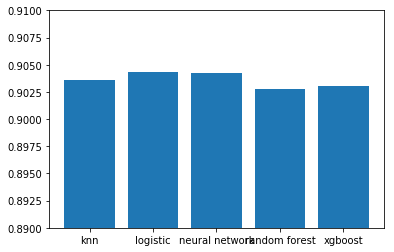

In [125]:
plt.bar(model_name,model_accuracy)
plt.ylim(0.89,0.91)
plt.show()

In [ ]:
##here, we choose knn as the ultimate model for prediction

In [ ]:
##because "Artist", "Auction","CanvasColor","Market","Nationality" are all not
## the top 100 important features and the features in training dataset
## and test dataset are not the same. so here, we retrain the model
## by excluding these feature-related variables.

In [ ]:
# data_train_new = pd.read_csv("train_dataset.csv")
# data_train_new = transform(data_train_new, _cates, cates_to_id, 
#                        id_to_cates, unique_years, dic)


In [ ]:
# data_train_new = data_train_new.drop(features_not_used,axis=1)
# data_train_new = data_train_new.dropna(axis=0)
# data_train_new.shape

In [126]:
data_train_new = pd.read_csv("../input/train_dataset.csv")
data_train_new = transform(data_train_new, _cates, cates_to_id, 
                       id_to_cates, unique_years, dic)

data_train_new = data_train_new.drop(features_not_used,axis=1)
data_train_new = data_train_new.fillna(method='ffill')
data_train_new.shape

train_label = data_train_new['IsBadBuy']

In [67]:
#knn

In [68]:
model_knn_new = KNeighborsClassifier(n_neighbors = score.index(max(score)))
model_knn_new = model_knn_new.fit(data_train_new.drop('IsBadBuy',axis=1),
                                  train_label)

In [69]:
cross_val_score(model_knn_new,data_train_new,train_label,cv=5).mean()

0.8728272791746046

In [139]:
model_knn_new = KNeighborsClassifier(n_neighbors = score.index(max(score)))
model_knn_new = model_knn_new.fit(data_train_new.drop('IsBadBuy',axis=1),
                                  train_label)

In [70]:
#logistic

In [130]:
test_model = LogisticRegression().fit(data_train_new.drop('IsBadBuy',axis=1),train_label)

In [131]:
#xgboost
test_size = int(data_train_new.shape[0] * 0.33)
test_X, train_X = split_set(data_train_new.drop('IsBadBuy',axis=1), test_size)
test_Y, train_Y = split_set(train_label, test_size)
# train_X,test_X,train_Y,test_Y = train_test_split(X, y, test_size=0.33, random_state=42)
xg_train = xgb.DMatrix(train_X, label=train_Y)  
xg_test = xgb.DMatrix(test_X, label=test_Y) 
watchlist = [ (xg_train,'train'), (xg_test, 'test') ] 
xgbst = xgb.train(param, xg_train, 100, watchlist)
yprob = xgbst.predict(xg_test)
ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro  
xg_accuracy = (ylabel == test_Y).mean()
xg_accuracy

[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	train-mlogloss:0.665272	test-mlogloss:0.665538
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	train-mlogloss:0.640077	test-mlogloss:0.640596
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[2]	train-mlogloss:0.617242	test-mlogloss:0.618008
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 

[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[30]	train-mlogloss:0.39198	test-mlogloss:0.396996
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[31]	train-mlogloss:0.39012	test-mlogloss:0.395228
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[32]	train-mlogloss:0.388415	test-mlogloss:0.393607
[17:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[60]	train-mlogloss:0.37164	test-mlogloss:0.378397
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[61]	train-mlogloss:0.371518	test-mlogloss:0.378309
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[62]	train-mlogloss:0.371406	test-mlogloss:0.37823
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[90]	train-mlogloss:0.370288	test-mlogloss:0.377669
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[91]	train-mlogloss:0.370277	test-mlogloss:0.377666
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[92]	train-mlogloss:0.370266	test-mlogloss:0.377668
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:10:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

0.8745477193190581

In [132]:
# Using KFold to train multiple models and average the result
test = pd.read_csv("../input/test_dataset.csv")
test_name = test.RT13Id
test = transform(test, _cates, cates_to_id, 
                 id_to_cates, unique_years, dic)
test = test.drop(features_not_used,axis=1)
test = test.fillna(method='ffill')
test.shape

(21895, 52)

In [133]:
test_xgbst = xgb.DMatrix(test)
output_xgbst = xgbst.predict(xg_test)
output_xgbst = np.argmax(output_xgbst, axis=1)

In [134]:
# output = test_model.predict(test)

In [135]:
clf_nn = MLPClassifier(hidden_layer_sizes=(32, 8), random_state=1)

clf_nn.fit(data_train_new.drop('IsBadBuy',axis=1),train_label)
output = clf_nn.predict(test)

In [136]:
###knn
output = model_knn_new.predict(test)

In [ ]:
# # LGBM feature importance analysis
# def lgb_model(x_train, x_test, y_train, y_test):
#     params = {
#         "objective" : "binary",
#         "metric" : "binary_error",
#         "num_leaves" : 20,
#         "learning_rate" : 0.1,
#         "bagging_fraction" : 0.8,
#         "feature_fraction" : 0.8,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 42,
#         "verbosity" : -1,
#         "max_depth" : 6
#     }
#     train = lgb.Dataset(x_train, label=y_train)
#     test = lgb.Dataset(x_test, label=y_test)
#     model = lgb.train(params, train, 1000, valid_sets=[test], early_stopping_rounds=300, verbose_eval=200)
#     return model

In [ ]:
# num_kfold = 3
# kf = model_selection.KFold(n_splits=num_kfold, shuffle=True, random_state=666)

# target = pd.DataFrame(columns=['RT13Id', 'IsBadBuy'])
# target['RT13Id'] = test['RT13Id']
# target['IsBadBuy'] = 0
# for t_idx, v_idx in kf.split(x_train):
#     t_x, v_x = x_train.loc[t_idx, :], x_train.loc[v_idx, :]
#     t_y, v_y = y_train[t_idx], y_train[v_idx]
#     model = lgb_model(t_x, v_x, t_y, v_y)
#     target['IsBadBuy'] += model.predict(x_test)

In [ ]:
# target['IsBadBuy'] = round(target['IsBadBuy'] / float(num_kfold), 0)
# target.to_csv('submission.csv', index=False)

In [132]:
sum(train_label.tolist())/len(train_label)

0.12310131537738804

In [79]:
# output.to_csv("../output/Shin_Gao_tg2618.csv",index=False,sep=',',encoding='utf-8-sig')

In [137]:
output = pd.DataFrame(output)
test_output = pd.concat([pd.DataFrame(test_name),output],axis=1)
test_output.rename(columns={test_output.columns[1]:'IsBadBuy'},inplace=True)
test_output

,RT13Id,IsBadBuy
0,1,0
1,7,0
2,8,0
3,20,0
4,21,0
5,25,0
6,27,0
7,30,0
8,32,0
9,33,0


In [138]:
test_output.to_csv("../output/Shin_Gao_tg2618.csv",index=False,sep=',',encoding='utf-8-sig')

In [84]:
# data_train_new.to_csv("../output/final_train.csv",index=False,sep=',',encoding='utf-8-sig')
# test.to_csv("../output/final_test.csv",index=False,sep=',',encoding='utf-8-sig')